# Unicast Simulation of a Quantum Network

## 1.0 Importing Libraries


In [1]:
import numpy as np
import sys
from random import choices #For randomized policy
from statistics import mean 
from tqdm import tqdm

## 2.0 Graphs Used (Run only one)

In [3]:
N = 2
A= np.zeros((N,N));
Key_rate= np.zeros((N,N));
A[0][1]=1
Key_rate[0][1]=0.5;
start = 0; dest = 1

In [4]:
# A 3 x 3 grid

N= 9
A= np.zeros((N,N));
Key_rate= np.zeros((N,N));  #Expected Key Arrival Rate
C_tilde = np.zeros((N,N));


A[0][1]=1;
A[0][3]=1;
A[1][1]=1;
A[1][4]=1;
A[2][5]=1;
A[3][4]=1;
A[3][6]=1;
A[4][5]=1;
A[4][7]=1;
A[5][8]=1;
A[6][7]=1;
A[7][8]=1;

Key_rate[0][1]=0.5;
Key_rate[0][3]=0.5;
Key_rate[1][1]=0.5;
Key_rate[1][4]=0.5;
Key_rate[2][5]=0.5;
Key_rate[3][4]=0.5;
Key_rate[3][6]=0.5;
Key_rate[4][5]=0.5;
Key_rate[4][7]=0.5;
Key_rate[5][8]=0.5;
Key_rate[6][7]=0.5;
Key_rate[7][8]=0.5;

start = 0; dest = 8

In [89]:
# Test Graph 1 ( A 6 node network )
N=6;
A= np.zeros((N,N));
Key_rate= np.zeros((N,N));  #Expected Key Arrival Rate
C_tilde = np.zeros((N,N));

A[0][1]=1;
A[0][2]=1;
A[1][3]=1;
A[1][4]=1;
A[2][3]=1;
A[3][4]=1;
A[4][5]=1;
A[3][5]=1;

Key_rate[0][1]=0.5;
Key_rate[0][2]=0.5;
Key_rate[1][3]=0.6;
Key_rate[1][4]=0.7;
Key_rate[2][3]=0.4;
Key_rate[3][4]=0.5;
Key_rate[4][5]=0.3;
Key_rate[3][5]=0.7;

start = 0; dest = 5

In [109]:
# Test Graph 2 ( A 11 node crazy network )
N=11;
A= np.zeros((N,N));
Key_rate= np.zeros((N,N));  #Expected Key Arrival Rate
C_tilde = np.zeros((N,N));

A[0][1]=1;
A[0][3]=1;
A[0][4]=1;
A[1][2]=1;
A[3][5]=1;
A[4][6]=1;
A[2][7]=1;
A[5][7]=1;
A[5][8]=1;
A[6][8]=1;
A[7][9]=1;
A[8][10]=1;
A[9][10]=1;

Key_rate[0][1]=0.5;
Key_rate[0][3]=0.5;
Key_rate[0][4]=0.5;
Key_rate[1][2]=0.5;
Key_rate[3][5]=0.5;
Key_rate[4][6]=0.5;
Key_rate[2][7]=0.5;
Key_rate[5][7]=0.3;
Key_rate[5][8]=0.3;
Key_rate[6][8]=0.3;
Key_rate[7][9]=0.3;
Key_rate[8][10]=0.3;
Key_rate[9][10]=0.3;

start = 0; dest = 10

In [6]:
# Test Graph 3 ( A 10x10 grid)
N=100;
A= np.zeros((N,N));
Key_rate= np.zeros((N,N));  #Expected Key Arrival Rate
C_tilde = np.zeros((N,N));

for i in range (N-1):
    if((i+1)%10 == 0):
        A[i][i+10]= 1
        Key_rate[i][i+10]= 0.5
    else:
        if(i>=90):
            A[i][i+1] = 1
            Key_rate[i][i+1] = 0.5
        else:
            A[i][i+10]= 1
            A[i][i+1] = 1
            Key_rate[i][i+10] = 0.5
            Key_rate[i][i+1] = 0.5
            
start = 0; dest = 99

## 3.0 Pre-Simulation Network Setup (Run all)

### Make Adjacency list 

In [90]:
n = N   #Number of Nodes

m = 0  #Counting number of edges
E = [] #Storing as adjacency list of edges

#Constructing Adjacency list and C_tilde matrix for capacity
for i in range(N):
    for j in range(N):
        if(A[i][j]!=0):
            m = m+1
            E.append([i,j,A[i][j],Key_rate[i][j]])
        C_tilde[i][j] = min(A[i][j],Key_rate[i][j])

### Finding Min-Cut using Ford Fulkerson Algorithm

Ford Fulkerson can be used to find the max-flow in the graph. We will fix our capacity region $\lambda$ at 95% of the estimated upper bound, which is given as the min cut of graph where edge capacities $\tilde{c}_e = min(c_e,\eta_e)$

In [91]:
def BFS(graph,s, t, parent): 

    # Mark all the vertices as not visited 
    visited =[False]*(m) 

    # Create a queue for BFS 
    queue=[] 

    # Mark the source node as visited and enqueue it 
    queue.append(s) 
    visited[s] = True

     # Standard BFS Loop 
    while queue: 

        #Dequeue a vertex from queue and print it 
        u = queue.pop(0) 

        # Get all adjacent vertices of the dequeued vertex u 
        for ind, val in enumerate(graph[u]): 
            if visited[ind] == False and val > 0 : 
                queue.append(ind) 
                visited[ind] = True
                parent[ind] = u 

    # If we reached sink in BFS starting from source, then return 
    # true, else false 
    return True if visited[t] else False


def FordFulkerson(graph, source, sink): 

    # This array is filled by BFS and to store path 
    parent = [-1]*(m) 

    max_flow = 0 # There is no flow initially 

    # Augment the flow while there is path from source to sink 
    while BFS(graph, source, sink, parent) : 

        # Find minimum residual capacity of the edges along the 
        # path filled by BFS. Or we can say find the maximum flow 
        # through the path found. 
        path_flow = float("Inf") 
        s = sink 
        while(s !=  source): 
            path_flow = min (path_flow, graph[parent[s]][s]) 
            s = parent[s] 

        # Add path flow to overall flow 
        max_flow +=  path_flow 

        # update residual capacities of the edges and reverse edges 
        # along the path 
        v = sink 
        while(v !=  source): 
            u = parent[v] 
            graph[u][v] -= path_flow 
            graph[v][u] += path_flow 
            v = parent[v] 

    return max_flow 

lamb = FordFulkerson(C_tilde, start, dest)  #Working at 95% of capacity

In [8]:
lamb = lamb*0.95

In [92]:
lamb

0.9

### Finding minima path
We use bellman ford/ dijikstra's algorithm on a graph with edge weights dependent on the algo

In [93]:
def minDistance(dist, sptSet): 

    # Initilaize 
    min = sys.maxsize 

    # Search not nearest vertex not in the shortest path tree 
    for v in range(n): 
        if (dist[v] < min and sptSet[v] == False): 
            min = dist[v] 
            min_index = v
    return min_index 

def dijkstra(graph, src, sink): 
  
    dist = [sys.maxsize]*n
    dist[src] = 0
    sptSet = [False]*n
    route = [None]*n
    last_node = [None]*n

    for cout in range(n): 
        
        u = minDistance(dist, sptSet) 
        if(u==src):
            route[u] = [u]
        else:
            route[u] = route[last_node[u]]+[u]
        sptSet[u] = True

        for v in range(n): 
            if (A[u][v]!= 0 and sptSet[v] == False and dist[v] > (dist[u] + graph[u][v])):
                dist[v] = dist[u] + graph[u][v]
                last_node[v]= u
    return route


def bellmanFord(graph,src,sink):
    # init all distances from source to all as INFINITE
    dist = [float("Inf")]*n
    dist[src] = 0
    route = [None]*n
    route[src] = [src]
    # relax all edges |V|-1 times.
    for i in range(n-1):
        # update dist value and parent index of adjacent values of picked vertex.
        # consider those which are still in queue.
        for u, v, w in graph:
            if dist[u] != float("Inf") and dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                route[v] = route[u]+[v]
    # check for negative weight cycles. If path obtained from above step (shortest distances)
    # is shorter, there's a cycle. So quit.
    for u, v, w in graph:
        if dist[u] != float("Inf") and dist[u] + w < dist[v]:
            print("Negative Cycles !")
            return
    # print distances
    return route

In [94]:
class packet:
    def __init__(self,i,t, r, d):
        self.index = i
        self.time = t
        self.route = r
        self.dist = d
        
from collections import deque

class Queue():  #A FIFO queue

    def __init__(self, max_size = sys.maxsize):
        self._queue = deque(maxlen=max_size)
        self.size = 0
        
    def isEmpty(self):
        return self.size == 0
    
    def returnLen(self):
        return self.size 

    def enqueue(self, item):
        self._queue.append(item)
        self.size = self.size + 1

    def dequeue(self):
        if (self.size > 0):
            self.size = self.size - 1
            return self._queue.pop()          
        else:
            return (-1)

def route_edge_set(route):
    route_edge = []
    for j in range (len(route)-1):
        for i in range(m):
            if(E[i][0]==route[j] and E[i][1]==route[j+1]):
                route_edge.append(i)
    return route_edge

def edge_index(x,y):
    for i in range (m):
        if (E[i][0]==x and E[i][1]== y):
            return i
    return -1

In [12]:
edge_index(0,4)

-1

In [13]:
def sign(x):
    if (x>0):
        return 1
    elif(x==0):
        return 0
    else:
        return -1

## 4.0 Network Algorithms

### 2 Queues in Tandem with Storage of Keys

In [106]:

def TandemStored(T, arr, key_arr):
    
    Qv1 = np.zeros(m)   #Virtual Queue 1
    Qv2 = np.zeros(m)   #Virtual Queue 2
    
    S = np.zeros(m)
    
    Q_sum = np.zeros(T)


    Q1 = []   #These are m queues for edges 
    Q2 = [] 
    for i in range(m):
        obj1 = Queue()
        obj2 = Queue()
        Q1.append(obj1)
        Q2.append(obj2)

    for t in range(T):
        a=arr[t]       # Arrival to the source 
        
        for i in range(m):
            S[i] = S[i] + key_arr[i][t]
            
        #Setting the weight of our graph whose min path is to be computed
        # as the length of virtual queues 
        G = []
        for i in range(m):
            G.append([ E[i][0], E[i][1], Qv1[i]+Qv2[i] ])  

        routes = bellmanFord(G,start,dest)
        #Converting route as sequence of nodes to sequence of edges

        route_edge = route_edge_set(routes[dest])

        for i in range(len(route_edge)):
            Qv1[route_edge[i]] = Qv1[route_edge[i]] + a
            Qv2[route_edge[i]] = Qv2[route_edge[i]] + a

        #print("Arr:", a, "Key arr:",key_arr[0][t], "Virt Q1:", Qv1, "Virt Q2:", Qv2, "Q1: ", Q1[0].returnLen(), "Q2: ",  Q2[0].returnLen(), "\n") 
            #print(V_len)

        for j in range(a):
            p = [0,t,route_edge,0]
            Q1[route_edge[0]].enqueue(p) 
            
        #print("Arr:", a, "Key arr:",key_arr[0][t], "Virt Q1:", Qv1, "Virt Q2:", Qv2, "Q1: ", Q1[0].returnLen(), "Q2: ",  Q2[0].returnLen(), "\n") 
        # Physical Queue Updation
        obj = []
        for i in range(m):
            
            #Transferring from Q1 to Q2
            used_key_count = 0
            for j in range(int(S[i])):
                g = Q1[i].dequeue()
                if(g!= -1):
                    Q2[i].enqueue(g)
                    used_key_count = used_key_count + 1
            obj.append(Q2[i].dequeue())  #Assuming service process is limited to 1 packet per slot   
            
            #Update key count
            S[i] = S[i] - used_key_count                     
                    
            #Updating Virtual Queues        
            if(Qv2[i]>0):
                Qv2[i] = Qv2[i]-1 
                
            Qv1[i] = Qv1[i]-key_arr[i][t]
            if(Qv1[i]<0):
                Qv1[i] = 0
            
        for i in range(m):   
            if(obj[i]!=-1):
                cur_edge = obj[i][2][obj[i][3]]
                next_node = E[cur_edge][1] #Getting next node of packet in the route
                #Key Availability Constraint
                if (next_node!= dest):
                    next_edge = obj[i][2][obj[i][3]+1]
                    obj[i][3] = obj[i][3]+1
                    Q1[next_edge].enqueue(obj[i])                         

        for i in range(m): 
            Q_sum[t] = Q_sum[t] + Q1[i].returnLen() + Q2[i].returnLen()
        
        Q_sum[t] = Q_sum[t]/m
        
    return(Q_sum)

### 2 Queues in Tandem

In [105]:
def TandemQueues(T, arr, key_arr):
    
    Qv1 = np.zeros(m)   #Virtual Queue 1
    Qv2 = np.zeros(m)   #Virtual Queue 2
    
    Q_sum = np.zeros(T)


    Q1 = []   #These are m queues for edges 
    Q2 = [] 
    for i in range(m):
        obj1 = Queue()
        obj2 = Queue()
        Q1.append(obj1)
        Q2.append(obj2)

    for t in range(T):
        a=arr[t]       # Arrival to the source 
            
        #Setting the weight of our graph whose min path is to be computed
        # as the length of virtual queues 
        G = []
        for i in range(m):
            G.append([ E[i][0], E[i][1], Qv1[i]+Qv2[i] ])  

        routes = bellmanFord(G,start,dest)
        #Converting route as sequence of nodes to sequence of edges

        route_edge = route_edge_set(routes[dest])

        for i in range(len(route_edge)):
            Qv1[route_edge[i]] = Qv1[route_edge[i]] + a
            Qv2[route_edge[i]] = Qv2[route_edge[i]] + a

        #print("Arr:", a, "Key arr:",key_arr[0][t], "Virt Q1:", Qv1, "Virt Q2:", Qv2, "Q1: ", Q1[0].returnLen(), "Q2: ",  Q2[0].returnLen(), "\n") 
            #print(V_len)

        for j in range(a):
            p = [0,t,route_edge,0]
            Q1[route_edge[0]].enqueue(p) 
            
        #print("Arr:", a, "Key arr:",key_arr[0][t], "Virt Q1:", Qv1, "Virt Q2:", Qv2, "Q1: ", Q1[0].returnLen(), "Q2: ",  Q2[0].returnLen(), "\n") 
        # Physical Queue Updation
        obj = []
        for i in range(m):
            #Transferring from Q1 to Q2
            for j in range(key_arr[i][t]):
                g = Q1[i].dequeue()
                if(g!= -1):
                    Q2[i].enqueue(g)
            obj.append(Q2[i].dequeue())  #Assuming service process is limited to 1 packet per slot
            
            #Updating Virtual Queues        
            if(Qv2[i]>0):
                Qv2[i] = Qv2[i]-1 
                
            Qv1[i] = Qv1[i]-key_arr[i][t]
            if(Qv1[i]<0):
                Qv1[i] = 0
            
        for i in range(m):   
            if(obj[i]!=-1):
                cur_edge = obj[i][2][obj[i][3]]
                next_node = E[cur_edge][1] #Getting next node of packet in the route
                #Key Availability Constraint
                if (next_node!= dest):
                    next_edge = obj[i][2][obj[i][3]+1]
                    obj[i][3] = obj[i][3]+1
                    Q1[next_edge].enqueue(obj[i])                         

        for i in range(m): 
            Q_sum[t] = Q_sum[t] + Q1[i].returnLen() + Q2[i].returnLen()
        
        Q_sum[t] = Q_sum[t]/m
        
    return(Q_sum)


### DYNAMIC POLICY

In [37]:
def dynamic(T, arr, key_arr):
    Q = np.zeros(m)
    Q_sum = np.zeros(T)
    S = np.zeros(m)
    S_v = np.zeros(m)

    # Vaiables for recording the statistics 
    sum_Q_len=0
    avg_Q_len= np.zeros((1,T))

    Phy_Q = []   #These are m queues for edges 
    for i in range(m):
        obj = Queue()
        Phy_Q.append(obj)

    for t in range(T):
        a=arr[t]        # Arrival to the source 

        #Assuming Poisson Key Generation Process
        for i in range(m):
            K = key_arr[i][t]
            S[i] = S[i] + K
            S_v[i] = S_v[i] + K

        #Setting the weight of our graph whose min path is to be computed
        # as the difference of virtual queues and virtual key queues
        G = []
        for i in range(m):
            G.append([E[i][0],E[i][1], Q[i] - sign(S_v[i])])  # add  

        #Assigning optimal route through dijktras algo(Unicast)
        #routes = dijkstra(G,start,dest)
        routes = bellmanFord(G,start,dest)
        #print(G)
        #print(routes[dest])
        #Converting route as sequence of nodes to sequence of edges
        route_edge = route_edge_set(routes[dest])

        # Virtual Queue Updation - Arrival
        for i in range(len(route_edge)):
            Q[route_edge[i]] = Q[route_edge[i]]+a
            S_v[route_edge[i]] = S_v[route_edge[i]] - a

        #print(a,"Virt Q:", Q, "V.Key:", S_v, "R.Key:", S, "\n")

        for j in range(a):
            p = [0,t,route_edge,0]
            Phy_Q[route_edge[0]].enqueue(p)  

        # Physical Queue Updation

        obj = []
        for i in range(m):
            obj.append(Phy_Q[i].dequeue())  #Assuming service process is limited to 1 packet per slot

        for i in range(m):        
            if(obj[i]!=-1):
                cur_edge = obj[i][2][obj[i][3]]
                next_node = E[cur_edge][1] #Getting next node of packet in the route
                #Key Availability Constraint
                if(S[cur_edge]>0):
                    #Updating distance
                    if (next_node!= dest):
                        next_edge = obj[i][2][obj[i][3]+1]
                        obj[i][3] = obj[i][3]+1
                        Phy_Q[next_edge].enqueue(obj[i])                
                    Q[cur_edge] = Q[cur_edge]-1 #Updating Virtual Queues
                    S[cur_edge] = S[cur_edge]-1 #Updating Real Key Queues
                else:
                    Phy_Q[cur_edge].enqueue(obj[i])

        for i in range(m): 
            Q_sum[t] = Q_sum[t] + Q[i]

        Q_sum[t] = Q_sum[t]/m
    
    return(Q_sum)

### APM

We set a threshold $\Theta$ such that a link is active only when sufficient keys are present

In [16]:
def AssurePath(T, arr, key_arr, thresh):
    
    Q = np.zeros(m)   #Virtual Queue
    Q_sum = np.zeros(T)
    S = np.zeros(m)  #Actual Keys at each Edge
    S_v = np.zeros(m)  #Virtual Keys at each edge

    # Variables for recording the statistics 
    sum_Q_len=0
    avg_Q_len= np.zeros((1,T))

    # Number of current packet entered into the network
    Packet_index=0

    Phy_Q = []   #These are m queues for edges 
    for i in range(m):
        obj = Queue()
        Phy_Q.append(obj)

    V = Queue()  #Temporary storage at source
    #Storing the packet when min-cut of keys is 0, we will only use one V in single commodity case
    V_len = 0
    V_len_arr = np.zeros(T)

    for t in range(T):
        a=arr[t]       # Arrival to the source 

        for i in range(m):
            K = key_arr[i][t]
            S[i] = S[i] + K
            S_v[i] = S_v[i] + K

        #Setting the weight of our graph whose min path is to be computed
        # as the length of virtual queues 
        G = []
        for i in range(m):
            if(S_v[i] >= thresh):
                G.append([E[i][0],E[i][1], Q[i]])  
                
        for j in range(a):
            p = [0,t,None,0]
            V.enqueue(p) 
            V_len = V_len +1

        routes = bellmanFord(G,start,dest)
        #Converting route as sequence of nodes to sequence of edges

        if(routes[dest]!=None):
            route_edge = route_edge_set(routes[dest])
            y = min(V_len, thresh)
            for i in range(y):
                V_len = V_len-1
                packet = V.dequeue()
                packet[2] = route_edge
                Phy_Q[route_edge[0]].enqueue(packet)

            for i in range(len(route_edge)):
                Q[route_edge[i]] = Q[route_edge[i]] + y
                S_v[route_edge[i]] = S_v[route_edge[i]] - y

            #print(a,"Virt Q:", Q, "V.Key:", S_v, "R.Key:", S, "\n") 
            #print(V_len)

        # Physical Queue Updation
        obj = []
        for i in range(m):
            obj.append(Phy_Q[i].dequeue())  #Assuming service process is limited to 1 packet per slot

        for i in range(m):        
            if(obj[i]!=-1):
                cur_edge = obj[i][2][obj[i][3]]
                next_node = E[cur_edge][1] #Getting next node of packet in the route
                #Key Availability Constraint
                if(S[cur_edge]>0):
                    #Updating distance
                    if (next_node!= dest):
                        next_edge = obj[i][2][obj[i][3]+1]
                        obj[i][3] = obj[i][3]+1
                        Phy_Q[next_edge].enqueue(obj[i])            
                    S[cur_edge] = S[cur_edge]-1 #Updating Real Key Queues
                else:
                    Phy_Q[cur_edge].enqueue(obj[i])
            if(Q[i]>0):
                Q[i] = Q[i]-1 #Updating Virtual Queues
               
        V_len_arr[t] = V_len

        for i in range(m): 
            Q_sum[t] = Q_sum[t] + Phy_Q[i].returnLen() 
        
        Q_sum[t] = Q_sum[t] + V_len
        Q_sum[t] = Q_sum[t]/m
        
    return(Q_sum)


### Heuristic APM


In [39]:
def HeuristicAPM(T, arr, key_arr, thresh):
    
    Q_sum = np.zeros(T)
    S = np.zeros(m)  #Actual Keys at each Edge
    S_v = np.zeros(m)  #Virtual Keys at each edge

    # Variables for recording the statistics 
    sum_Q_len=0
    avg_Q_len= np.zeros((1,T))

    # Number of current packet entered into the network
    Packet_index=0

    Phy_Q = []   #These are m queues for edges 
    for i in range(m):
        obj = Queue()
        Phy_Q.append(obj)

    V = Queue()  #Temporary storage at source
    #Storing the packet when min-cut of keys is 0, we will only use one V in single commodity case
    V_len = 0
    V_len_arr = np.zeros(T)

    for t in range(T):
        a=arr[t]       # Arrival to the source 

        #Assuming Poisson Key Generation Process
        for i in range(m):
            K = key_arr[i][t]
            S[i] = S[i] + K
            S_v[i] = S_v[i] + K

        #Setting the weight of our graph whose min path is to be computed
        # as the length of 1virtual queues 
        G = []
        for i in range(m):
            if(S_v[i] >= thresh):
                G.append([E[i][0],E[i][1], Phy_Q[i].returnLen()])  

        for j in range(a):
            p = [0,t,None,0]
            V.enqueue(p) 
            V_len = V_len +1

        routes = bellmanFord(G,start,dest)
        #Converting route as sequence of nodes to sequence of edges

        if(routes[dest]!=None):
            route_edge = route_edge_set(routes[dest])
            y = min(V_len, thresh)
            for i in range(y):
                V_len = V_len-1
                packet = V.dequeue()
                packet[2] = route_edge
                Phy_Q[route_edge[0]].enqueue(packet)

            for i in range(len(route_edge)):
                S_v[route_edge[i]] = S_v[route_edge[i]] - y

            #print(a,"Virt Q:", Q, "V.Key:", S_v, "R.Key:", S, "\n") 
            #print(V_len)

        # Physical Queue Updation
        obj = []
        for i in range(m):
            obj.append(Phy_Q[i].dequeue())  #Assuming service process is limited to 1 packet per slot

        for i in range(m):        
            if(obj[i]!=-1):
                cur_edge = obj[i][2][obj[i][3]]
                next_node = E[cur_edge][1] #Getting next node of packet in the route
                #Key Availability Constraint
                if(S[cur_edge]>0):
                    #Updating distance
                    if (next_node!= dest):
                        next_edge = obj[i][2][obj[i][3]+1]
                        obj[i][3] = obj[i][3]+1
                        Phy_Q[next_edge].enqueue(obj[i])                
                     #Updating Virtual Queues
                    S[cur_edge] = S[cur_edge]-1 #Updating Real Key Queues
                else:
                    Phy_Q[cur_edge].enqueue(obj[i])

        V_len_arr[t] = V_len

        for i in range(m): 
            Q_sum[t] = Q_sum[t] + Phy_Q[i].returnLen()

        Q_sum[t] = Q_sum[t]/m
        
    return(Q_sum)


### Back Pressure

In [83]:
def BP(T, arr, key_arr):
    
    Q_sum = np.zeros(T)
    Q = np.zeros(N) #Queue length at each node
    S = np.zeros(m)  #Actual Keys at each Edge
    sum_arr = 0

    # Variables for recording the statistics 
    sum_Q_len=0
    avg_Q_len= np.zeros((1,T))

    # Number of current packet entered into the network
    Packet_index=0

    Phy_Q = []   #These are n queues for nodes 
    for i in range(N):
        obj = Queue()
        Phy_Q.append(obj)


    for t in range(T):
        a=arr[t]       # Arrival to the source 
        sum_arr=sum_arr+a
        #print("time= ", t, "arr= ", a)
        for i in range(m):
            K = key_arr[i][t]
            S[i] = S[i] + K

        #Setting the weight of our graph whose min path is to be computed
        # as the length of virtual queues  
                
        for j in range(a):
            p = [0,t,None,0]
            Phy_Q[start].enqueue(p) 
        
        visited = np.zeros((N,N))
        
        for x in range(N):
            u = Q[x]
            #print("x= ", x)
            while (u>0):
                maxdiff = -99999999
                nextnode = -1
                for y in range(N):
                    if(A[x][y]==1  and Q[x]-Q[y]>maxdiff and visited[x][y]==0):
                        if (S[edge_index(x,y)]>0):
                            maxdiff = Q[x]-Q[y]
                            nextnode = y
                #print("nextnode=", nextnode)
                if(nextnode!=-1):
                    S[edge_index(x,nextnode)] = S[edge_index(x,nextnode)]-1
                    visited[x][nextnode]= 1
                    p = Phy_Q[x].dequeue()
                    if(nextnode!=dest):
                        Phy_Q[nextnode].enqueue(p)
                    
                u=u-1
        
        for i in range(N):
            Q[i] = Phy_Q[i].returnLen()
            Q_sum[t] = Q_sum[t] + Phy_Q[i].returnLen()
        
        Q_sum[t] = Q_sum[t]/m
        
    return(Q_sum)


### Randomized Policy

In [41]:
# Have to define route edge sets
route_set =[]
route_set.append([0,1,4,5])
route_set.append([0,1,3,5])
route_set.append([0,2,3,5])


T=5000

def Randomized(T, arr, k_arr):
    
    Q = np.zeros(m)
    Q_sum = np.zeros(T)
    S = np.zeros(m)
    S_v = np.zeros(m)

    # The Weight-vector would be simply the Q-vector
    W=np.zeros((n, n))

    # Vaiables for recording the statistics 
    sum_Q_len=0
    avg_Q_len= np.zeros((1,T))

    # Number of current packet entered into the network
    Packet_index=0

    # These variables keep track of tree usages
    # Initialize the global tree-base with the "zero-tree"

    Tree_base=np.zeros((n-1,2,1));

    #Number of trees =1
    Num_tree=1;

    # Usage vector keeps count of number of packets entering into the trees
    Usage=np.zeros((1,1));

    Phy_Q = []   #These are m queues for edges 
    for i in range(m):
        obj = Queue()
        Phy_Q.append(obj)

    k = 1 #The constant of proportion between virtual queues and key queues

    for t in range(T):
        a=arr[t]        # Arrival to the source 
        #sum_arr=sum_arr+a

        #Assuming Poisson Key Generation Process
        for i in range(m):
            K = k_arr[i][t]
            S[i] = S[i] + K
            S_v[i] = S_v[i] + K

        #Setting the weight of our graph whose min path is to be computed
        # as the difference of virtual queues and virtual key queues
        G = []
        for i in range(m):
            G.append([E[i][0],E[i][1], Q[i] - (S_v[i]/E[i][3])])

        i = choices(np.arange(3), [0.334, 0.222, 0.444])[0]
        route= route_set[i]
        #Assigning optimal route through dijktras algo(Unicast)
        #routes = dijkstra(G,start,dest)
        #routes = bellmanFord(G,start,dest)
        #print(G)
        #print(routes[dest])
        #Converting route as sequence of nodes to sequence of edges
        route_edge = route_edge_set(route)

        # Virtual Queue Updation - Arrival
        for i in range(len(route_edge)):
            Q[route_edge[i]] = Q[route_edge[i]]+a
            S_v[route_edge[i]] = S_v[route_edge[i]] - a

        #print(a,"Virt Q:", Q, "V.Key:", S_v, "R.Key:", S, "\n")

        for j in range(a):
            p = [0,t,route_edge,0]
            Phy_Q[route_edge[0]].enqueue(p)  

        # Physical Queue Updation

        obj = []
        for i in range(m):
            obj.append(Phy_Q[i].dequeue())  #Assuming service process is limited to 1 packet per slot

        for i in range(m):        
            if(obj[i]!=-1):
                cur_edge = obj[i][2][obj[i][3]]
                next_node = E[cur_edge][1] #Getting next node of packet in the route
                #Key Availability Constraint
                if(S[cur_edge]>0):
                    #Updating distance
                    if (next_node!= dest):
                        next_edge = obj[i][2][obj[i][3]+1]
                        obj[i][3] = obj[i][3]+1
                        Phy_Q[next_edge].enqueue(obj[i])                
                    Q[cur_edge] = Q[cur_edge]-1 #Updating Virtual Queues
                    S[cur_edge] = S[cur_edge]-1 #Updating Real Key Queues
                else:
                    Phy_Q[cur_edge].enqueue(obj[i])

        for i in range(m): 
            Q_sum[t] = Q_sum[t] + Phy_Q[i].returnLen()

        Q_sum[t] = Q_sum[t]/m
        
    return Q_sum


## 5.0 Simulation Run

In [139]:
g = sum_apm
h = sum_rand

In [115]:
T=10000

Thresh_Q = []

arr = np.random.poisson(0.9*lamb, T)  #Poisson arrival storing

key_arr = []
for i in range(m):
    key_arr.append(np.random.poisson(E[i][3], T))
    
Q1_sum =TandemQueues(T, arr, key_arr)
Q2_sum = AssurePath(T, arr, key_arr, 2)
Q4_sum = BP(T, arr, key_arr)   
Q3_sum = TandemStored(T, arr, key_arr) 
#for thresh in tqdm(range(1,6)):
#    Thresh_Q.append(AssurePath(T, arr, key_arr,thresh))



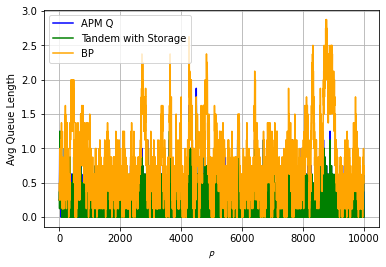

In [118]:
import matplotlib.pyplot as plt

plt.plot(Q2_sum, color = 'blue', label = 'APM Q')
plt.plot(Q3_sum, color = 'green', label = 'Tandem with Storage')
#plt.plot(Q1_sum, color = 'red', label = 'Tandem Q')

plt.plot(Q4_sum, color = 'orange', label = 'BP')

plt.xlabel("$\mathcal{p}$")
plt.ylabel("Avg Queue Length")
plt.grid()
plt.legend()
plt.show()

In [129]:
from scipy.signal import savgol_filter
w1 = savgol_filter(w1, 7, 2)
w2 = savgol_filter(w2, 7, 2)
w3 = savgol_filter(w3, 7, 2)
w4 = savgol_filter(w4, 7, 2)
#w5 = savgol_filter(data5, 3, 2)

In [ ]:
smoother = ConvolutionSmoother(window_len=30, window_type='ones')
smoother.smooth(y)

In [124]:
T=1000 
num = 300
points = 20
prec = 0.05

Thresh_Q = []
Thresh_V = []

apm_q_len = []
Heur_q_len = []


sum_apm = np.zeros(points+1)
sum_bp = np.zeros(points+1)
sum_tq = np.zeros(points+1)
sum_ts = np.zeros(points+1)
sum_rand = np.zeros(points+1)
sum_dynam = np.zeros(points+1)


for j in tqdm(range(num)):
    for p in tqdm(range(points+1)):  
        #The threshold that determines whether there is minimum that many keys in each edge. Should try thresh = max(c_e)

        arr = np.random.poisson(prec*p*lamb, T)  #Poisson arrival storing

        key_arr = []
        for i in range(m):
            key_arr.append(np.random.poisson(E[i][3], T))

        #apm_mean = mean(AssurePath(T, arr, key_arr,2))
        tq_mean = mean(TandemQueues(T,arr,key_arr))
        ts_mean = mean(TandemStored(T,arr,key_arr))
        bp_mean = mean(BP(T,arr,key_arr))
        #rand_mean = mean(Randomized(T,arr,key_arr))
        #dynam_mean = mean(dynamic(T,arr,key_arr))

        #sum_apm[p] = sum_apm[p] + apm_mean
        sum_bp[p] = sum_bp[p] + bp_mean
        sum_tq[p] = sum_tq[p] + tq_mean
        sum_ts[p] = sum_ts[p] + ts_mean
        #sum_rand[p] = sum_rand[p] + rand_mean
        #sum_dynam[p] = sum_dynam[p] + dynam_mean

 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [00:13<00:05,  1.10it/s]


 43%|███████████████████████████████████▌                                               | 9/21 [00:08<00:10,  1.18it/s]


 14%|███████████▊                                                                       | 3/21 [00:02<00:17,  1.01it/s]


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [00:15<00:00,  1.46it/s]


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [00:18<00:07,  1.13s/it]


 38%|███████████████████████████████▌                                                   | 8/21 [00:07<00:11,  1.14it/s]


 10%|███████▉                                                                           | 2/21 [00:02<00:20,  1.10s/it]


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [00:15<00:01,  1.39it/s]


 62%|██████████████████████████████████████████████████▊                               | 13/21 [00:11<00:06,  1.28it/s]


 33%|███████████████████████████▋                                                       | 7/21 [00:06<00:12,  1.08it/s]


  5%|███▉                                                                               | 1/21 [00:00<00:17,  1.11it/s]


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [00:14<00:02,  1.39it/s]


 57%|██████████████████████████████████████████████▊                                   | 12/21 [00:10<00:07,  1.28it/s]


 29%|███████████████████████▋                                                           | 6/21 [00:05<00:13,  1.15it/s]


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [00:13<00:02,  1.42it/s]


 52%|██████████████████████████████████████████▉                                       | 11/21 [00:09<00:07,  1.29it/s]


 24%|███████████████████▊                                                               | 5/21 [00:04<00:13,  1.19it/s]


 36%|█████████████████████████████                                                   | 109/300 [32:25<52:58, 16.64s/it]


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [00:13<00:03,  1.40it/s]


 48%|███████████████████████████████████████                                           | 10/21 [00:08<00:09,  1.18it/s]


 19%|███████████████▊                                                                   | 4/21 [00:03<00:15,  1.09it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [00:12<00:04,  1.29it/s]


 43%|███████████████████████████████████▌                                               | 9/21 [00:07<00:09,  1.23it/s]


 14%|███████████▊                                                                       | 3/21 [00:02<00:17,  1.05it/s]


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [00:16<00:00,  1.38it/s]


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [00:11<00:05,  1.36it/s]


 38%|███████████████████████████████▌                                                   | 8/21 [00:07<00:11,  1.14it/s]


 10%|███████▉                                                                           | 2/21 [00:01<00:17,  1.11it/s]


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [00:15<00:01,  1.49it/s]


 62%|██████████████████████████████████████████████████▊                               | 13/21 [00:11<00:06,  1.22it/s]


 33%|███████████████████████████▋                                                       | 7/21 [00:06<00:11,  1.18it/s]


  5%|███▉                                                                               | 1/21 [00:01<00:20,  1.00s/it]


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [00:14<00:02,  1.48it/s]


 57%|██████████████████████████████████████████████▊                                   | 12/21 [00:10<00:07,  1.27it/s]


 29%|███████████████████████▋                                                           | 6/21 [00:05<00:14,  1.07it/s]


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [00:13<00:02,  1.43it/s]


 52%|██████████████████████████████████████████▉                                       | 11/21 [00:09<00:07,  1.26it/s]


 24%|███████████████████▊                                                               | 5/21 [00:04<00:14,  1.11it/s]


 80%|██████████████████████████████████████████████████████████████▋               | 241/300 [1:09:04<16:26, 16.71s/it]


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [00:13<00:03,  1.31it/s]


 48%|███████████████████████████████████████                                           | 10/21 [00:09<00:09,  1.16it/s]


 19%|███████████████▊                                                                   | 4/21 [00:03<00:15,  1.11it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [00:12<00:04,  1.35it/s]


 43%|███████████████████████████████████▌                                               | 9/21 [00:07<00:09,  1.21it/s]


 14%|███████████▊                                                                       | 3/21 [00:02<00:17,  1.03it/s]


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [00:15<00:00,  1.44it/s]


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [00:11<00:05,  1.33it/s]


 38%|███████████████████████████████▌                                                   | 8/21 [00:06<00:10,  1.19it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [1:25:23<00:00, 17.08s/it]


In [125]:
for p in range(points+1):
    #sum_apm[p] = sum_apm[p]/num
    sum_bp[p] = sum_bp[p]/num
    sum_tq[p] = sum_tq[p]/num
    sum_ts[p] = sum_ts[p]/num
    #sum_rand[p] = sum_rand[p]/num
    #sum_dynam[p] = sum_dynam[p]/num    

In [114]:
data11 = sum_apm
data21 = sum_bp
data31 = sum_rand

In [126]:
data1 = sum_apm
data2 = sum_tq
data3 = sum_ts
data4 = sum_bp

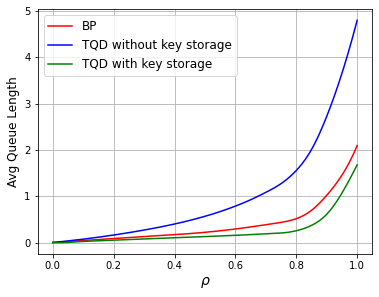

In [200]:
import matplotlib.pyplot as plt
p = np.arange(0,1+prec,prec)
plt.figure(figsize=(6,4.5))
#plt.plot(p,sum_rand, color = 'green', label = 'Rand')
plt.plot(xnew,bp, color = 'red', label = 'BP')
plt.plot(xnew,tq, color = 'blue', label = 'TQD without key storage')
plt.plot(xnew,ts, color = 'green', label = 'TQD with key storage')

plt.xlabel("$ρ$",fontsize=14)
plt.ylabel("Avg Queue Length", fontsize=12)
plt.grid()
plt.legend(prop={'size': 12})
#plt.show()
plt.savefig("fireee.png", dpi=600)

In [185]:
from scipy import interpolate
p = np.arange(0,1+prec,prec)
xnew = np.linspace(p.min(), p.max(), 500)
bp_smooth = interpolate.make_interp_spline(p, w4)
bp = bp_smooth(xnew)
tq_smooth = interpolate.make_interp_spline(p, w2)
tq = tq_smooth(xnew)
ts_smooth = interpolate.make_interp_spline(p, w3)
ts = ts_smooth(xnew)
#dyn_smooth = interpolate.make_interp_spline(p, sum_dynam)
#dyn = dyn_smooth(xnew)

## Analysis